In [97]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta, date

ModuleNotFoundError: No module named 'sklearn'

In [59]:
df = pd.read_csv("./result.csv")

In [60]:
df.info

<bound method DataFrame.info of                     Created_time  \
0     2021-12-19 17:24:20.384430   
1     2021-12-19 17:24:23.339806   
2     2021-12-19 17:24:27.288977   
3     2021-12-19 17:24:30.072343   
4     2021-12-19 17:24:35.264820   
...                          ...   
5039  2021-12-21 20:57:46.268335   
5040  2021-12-21 20:57:48.078832   
5041  2021-12-21 20:58:44.501472   
5042  2021-12-21 20:59:24.427815   
5043  2021-12-21 20:59:26.064551   

                                                    URL  \
0     https://www.olx.ua/d/obyavlenie/iphone-11-pro-...   
1     https://www.olx.ua/d/obyavlenie/apple-iphone-1...   
2     https://www.olx.ua/d/obyavlenie/zahisne-sklo-i...   
3     https://www.olx.ua/d/obyavlenie/zahisne-sklo-t...   
4     https://www.olx.ua/d/obyavlenie/topovoe-steklo...   
...                                                 ...   
5039  https://www.olx.ua/d/obyavlenie/telefon-siemen...   
5040  https://www.olx.ua/d/obyavlenie/remnets-dlya-a...   
5041

In [61]:
print(df.shape)
print(df[(df['Views'] != 'нет просмотров') & (df['Views'].notnull())].shape)

(5044, 14)
(3192, 14)


In [62]:
# filter data
df = df[(df['Views'] != 'нет просмотров') & (df['Views'].notnull()) & (df['URL'] != 'URL')]

In [117]:
TRUE_FALSE_MAP = {
    "True": 1,
    "False": 0
}

df = df.assign(views = df['Views'].apply(int))
df = df.assign(olxdelivery = df['OlxDelivery'].map(TRUE_FALSE_MAP))
df = df.assign(is_promoted = df['Is_promoted'].map(TRUE_FALSE_MAP))

In [63]:
def clean_url(url):
    res = re.search(r'(.*.html).*', url)
    if res:
        return res.group(1)
    else:
        print(url)
        return None
   
df = df.assign(cleaned_URL = df['URL'].apply(clean_url))

In [64]:
df.drop_duplicates('cleaned_URL').shape
df = df.drop_duplicates('cleaned_URL')

In [86]:
# add description len and number of lines in the description
df = df.assign(description_size = df['Description'].apply(lambda x: len(x)))
df = df.assign(description_lines = df['Description'].apply(lambda x: len(x.splitlines())))
df = df.assign(name_size = df['Name'].apply(lambda x: len(x)))

In [66]:
# fix Author_from_data

MONTHS = {
    'январь': 1,
    'февраль': 2,
    'март': 3,
    'апрель': 4,
    'май': 5,
    'июнь': 6,
    'июль': 7,
    'август': 8,
    'сентябрь': 9,
    'октябрь': 10,
    'ноябрь': 11,
    'декабрь': 12,
}

def clean_author_from_data(auth_date):
    split = auth_date.split()
    month = MONTHS[split[0]]
    year = split[1]
    return date(year=int(year), month=int(month), day=1)

df = df.assign(Author_from_data_cleaned = df["Author_from_data"].apply(clean_author_from_data))

In [67]:
df['Author_from_data_cleaned']

0       2012-03-01
1       2017-06-01
2       2016-12-01
3       2015-03-01
4       2017-10-01
           ...    
5028    2020-01-01
5029    2015-07-01
5030    2015-07-01
5036    2018-11-01
5041    2018-02-01
Name: Author_from_data_cleaned, Length: 2182, dtype: object

In [68]:
def get_city(address):
    split = address.split(',')
    city = split[0].strip()
    return city
df = df.assign(city = df["Address"].apply(get_city))
df['city']

0                  Киев
1                  Киев
2                 Львов
3                 Львов
4                  Киев
             ...       
5028       Кропивницкий
5029            Золочев
5030               Киев
5036            Харьков
5041    Ивано-Франковск
Name: city, Length: 2182, dtype: object

In [83]:
df = df.assign(
    time_on_olx_seconds = (pd.to_datetime(df['Created_time']) - pd.to_datetime(df['Date'])).dt.total_seconds()
)

In [84]:
df = df.assign(
    auth_days_on_olx = 
    (pd.to_datetime(df['Created_time']) - pd.to_datetime(df['Author_from_data_cleaned'])).dt.days
       )

In [89]:
df.groupby(['Auth_rating']).count()

,Created_time,URL,Name,Category,Price,Address,Date,OlxDelivery,Is_promoted,Author_from_data,...,Description,cleaned_URL,description_size,description_lines,Author_from_data_cleaned,city,auth_days_on_olx,time_on_olx,time_on_olx_seconds,name_size
Auth_rating,,,,,,,,,,,,,,,,,,,,,
Неудовлетворительно,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
Отлично,643,643,643,643,643,643,643,643,643,643,...,643,643,643,643,643,643,643,643,643,643
Удовлетворительно,157,157,157,157,157,157,157,157,157,157,...,157,157,157,157,157,157,157,157,157,157
Хорошо,450,450,450,450,450,450,450,450,450,450,...,450,450,450,450,450,450,450,450,450,450
нет ни одного отзыва,910,910,910,910,910,910,910,910,910,910,...,910,910,910,910,910,910,910,910,910,910


In [91]:
RATING_MAP = {
    'Отлично': 5,
    'Хорошо': 4,
    'Удовлетворительно': 3,
    'нет ни одного отзыва': 2,
    'Неудовлетворительно': 1,
}

In [92]:
df = df.assign(
    auth_rating_int = df['Auth_rating'].apply(lambda x: RATING_MAP[x])
       )

In [94]:
df[['auth_rating_int', 'Auth_rating']]

,auth_rating_int,Auth_rating
0,5,Отлично
1,5,Отлично
2,2,нет ни одного отзыва
3,2,нет ни одного отзыва
4,2,нет ни одного отзыва
...,...,...
5028,5,Отлично
5029,2,нет ни одного отзыва
5030,2,нет ни одного отзыва
5036,5,Отлично


<AxesSubplot:>

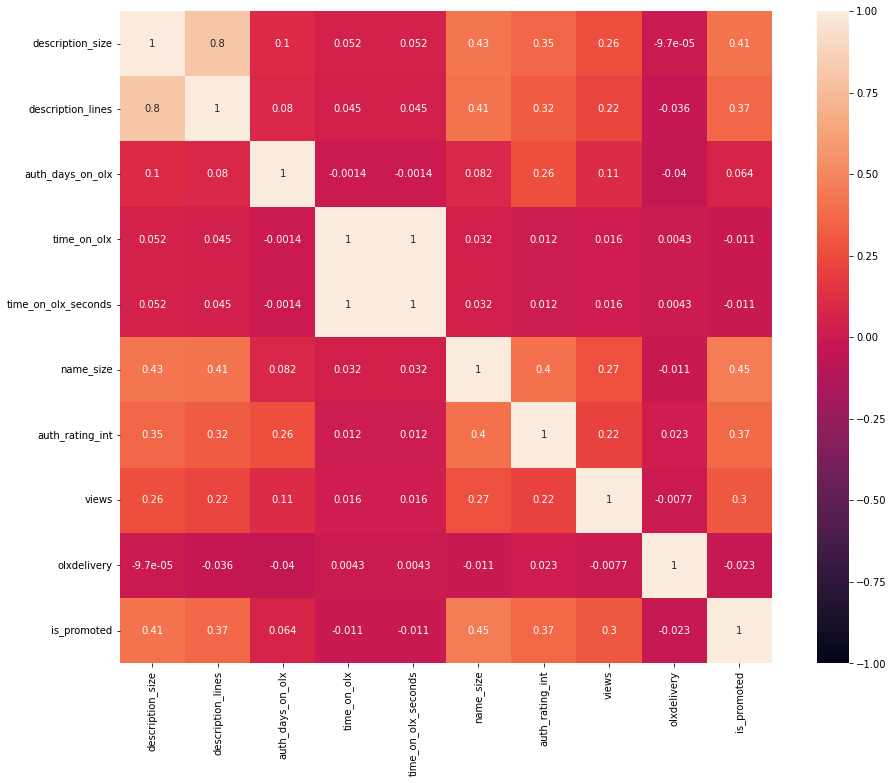

In [121]:
corr_matrix = df.corr()
plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, vmin = -1, vmax = 1, annot = True, square=True)

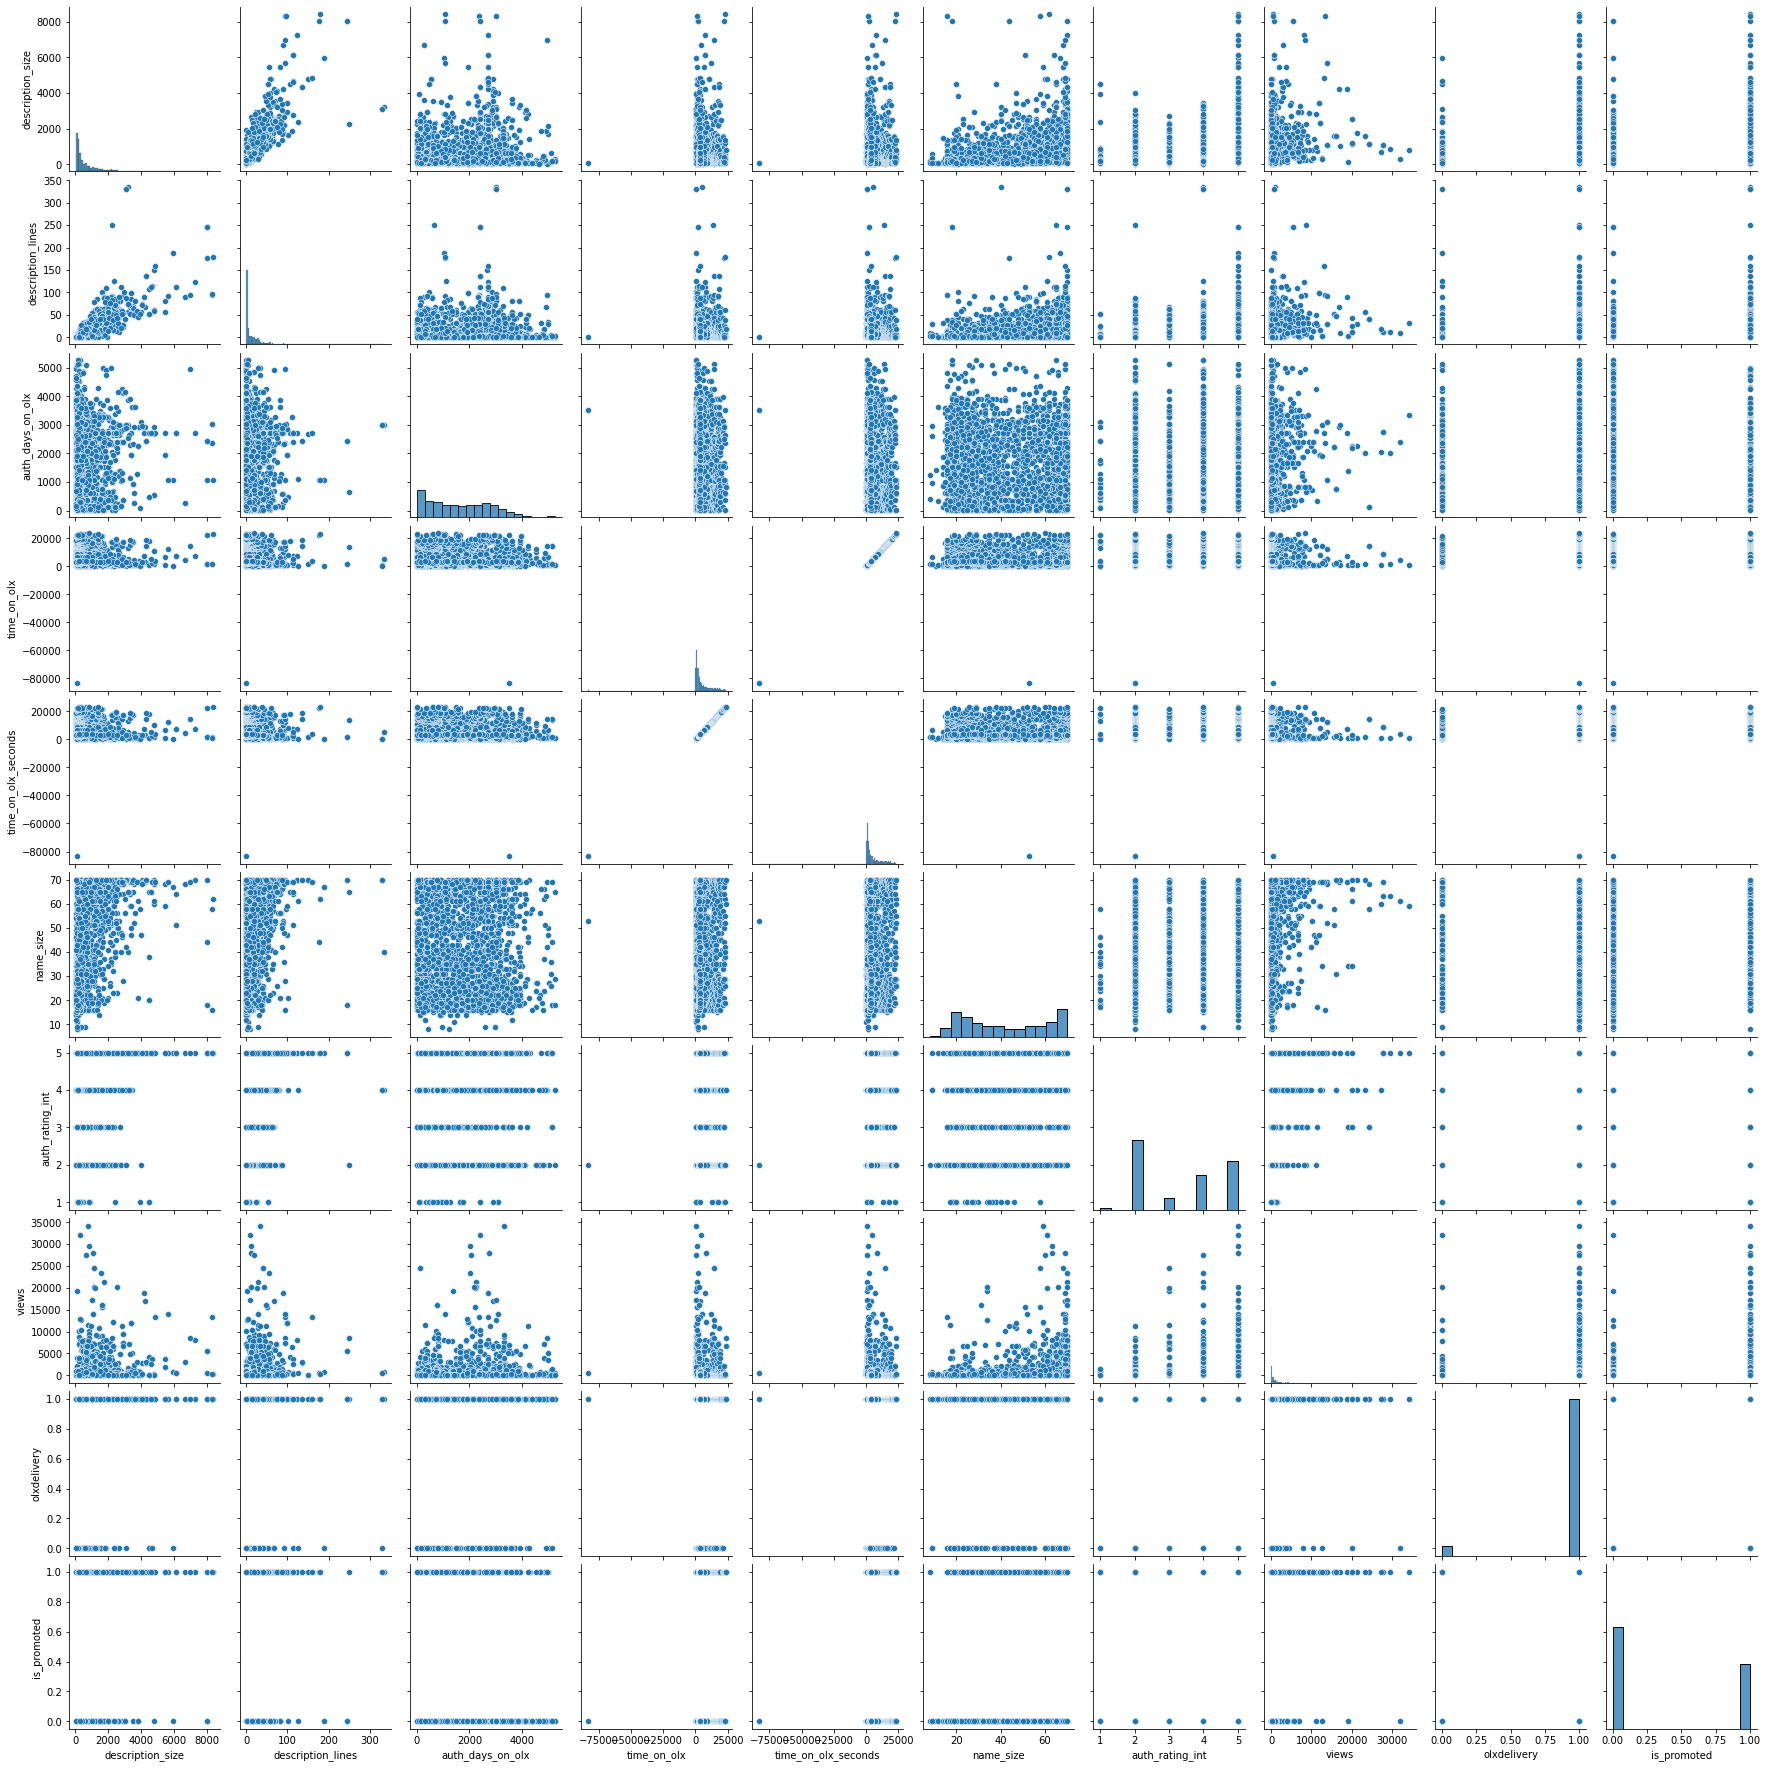

In [123]:
sns.pairplot(df)


In [126]:
df.groupby(['Category']).count()

,Created_time,URL,Name,Price,Address,Date,OlxDelivery,Is_promoted,Author_from_data,Views,...,Author_from_data_cleaned,city,auth_days_on_olx,time_on_olx,time_on_olx_seconds,name_size,auth_rating_int,views,olxdelivery,is_promoted
Category,,,,,,,,,,,,,,,,,,,,,
Автозапчасти и аксессуары » GPS-навигаторы / авторегистраторы,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Автозапчасти и аксессуары » Автозвук,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Автозапчасти и аксессуары » Аксессуары для авто,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Аксессуары » Бижутерия,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Аксессуары » Другие аксессуары,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Фото / видео » Экшн-камеры,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
"Хобби, отдых и спорт » Другое",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Электроника » Аксессуары и комплектующие,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
